Grover's algorithm, also known as the quantum search algorithm, allows unstructured search that finds with high probability the unique input to a black box function that produces a particular output value, using just $O({\sqrt {N}})$ evaluations of the function, where $N$ is the size of the function's domain.
We run Grover's algorithm on a 2-qubit circuit, the oracle encoding one of the 4 possible quantum states, and verify whether the measuremet outcome corresponds to the input state.

### Import modules

In [8]:
import qiclib as ql
from qiclib.code import *

from qiclib.packages.qiskit.QiController_backend import QiController_backend
from qiclib.packages.qiskit.QiController_provider import QiController_provider

import matplotlib.pyplot as plt

### Call QiController backend Slot3

In [9]:
qic = ql.QiController('slot3-platform')

Platform driver version: v0.1.0 +587 (e87b7dc2, 28.11.2021 20:36) <dirty>
Establishing gRPC connection to slot3-platform:50058...
Standard Qubit-Platform running on ZCU111 board
QiController firmware built 2021-11-28 20:35:34 (rev. 714)
Firmware with 10 digital unit cells detected.


### Add coupling map of qubits

In [10]:
# Add coupling map of qubits q0 and q1 (or q1 and q0) subject to the CNOT operation 
coupling_map = [[0,1]]

### Define the sample

In [11]:
# Define the sample of 3 cells; 2 cells correspond the 2 qubits of the circuit, and the 3rd cell is used
# for coupling q0 and q1
sample = QiCells(3) 

# First cell corresponds to the first qubit of the circuit
sample[0]["rec_pulse"] = 116e-9 # s readout pulse length
sample[0]["rec_length"] = 100e-9 # s recording window size
sample[0]["rec_frequency"] = 60e6 # Hz readout pulse frequency
sample[0]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[0]["rec_offset"] = 20e-9 # s electrical delay
sample[0]["pi"] = 160e-9 # s Pi pulse duration
sample[0]["T1"] = 2e-6 # s decoherence time
sample[0]["T2"] = 3e-6 # s dephasing time

# Second cell corresponds to the second qubit of the circuit
sample[1]["rec_pulse"] = 116e-9 # s readout pulse length
sample[1]["rec_length"] = 100e-9 # s recording window size
sample[1]["rec_frequency"] = 90e6 # Hz readout pulse frequency
sample[1]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[1]["rec_offset"] = 20e-9 # s electrical delay
sample[1]["pi"] = 160e-9 # s Pi pulse duration
sample[1]["T1"] = 2e-6 # s decoherence time
sample[1]["T2"] = 3e-6 # s dephasing 

# One additional cell to couple the two qubits q0 and q1, and apply the CNOT gate
sample[2]["gauss_on_pulse_length"] = 24e-9 # s 
sample[2]["rectangular_pulse_length"] = 132e-9 # s 
sample[2]["gauss_off_pulse_length"] = 24e-9 # s 
sample[2]["pulse_frequency"] = 854e6 # Hz

### Amplitude calibration

In [12]:
qic.cell[0].manipulation.amplitude_calibration = (0.5,0.5)
qic.cell[1].manipulation.amplitude_calibration = (0.5,0.5)

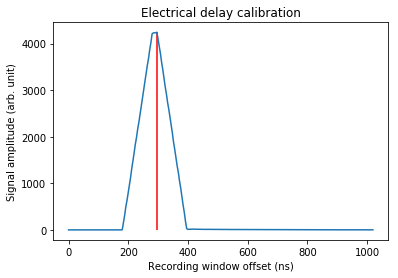

Optimal offset: 296.0 ns
Mirror sideband is 14.5 dB suppressed at recording input


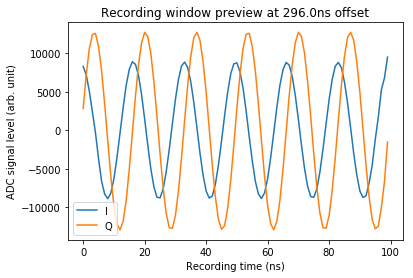

In [13]:
ql.init.calibrate_readout(qic, sample, averages=1000)

In [14]:
with QiJob() as job_test:
    
    q = QiCells(1)
    
    ql.jobs.Readout(q[0], "result")
    
job_test.run(qic, sample, averages=1000, data_collection="iqcloud")

In [15]:
result = job_test.cells[0].data("result")

### State calibration

In [16]:
from qiclib.packages.utility import calculate_stater_config

# Enter the coordinates of the seperation line to each cell of the sample seperately
qic.cell[0].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)
qic.cell[1].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)

### Call QiController provider and define backend

In [17]:
# Call the QiController hardware provider with the specified sample
provider = QiController_provider(qic, sample, coupling_map)

In [18]:
# Create a backend based on the given hardware provider and the sample
backend = QiController_backend(provider)

### Grover's Algorithm

In [19]:
# importing Qiskit
from qiskit import QuantumCircuit, Aer, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

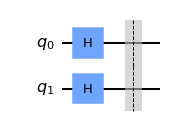

In [20]:
n = 2
grover_circuit = QuantumCircuit(n)

grover_circuit.h(0)
grover_circuit.h(1)
grover_circuit.barrier()

grover_circuit.draw(output='mpl')

Create the oracle encoding the $|10>$ state.

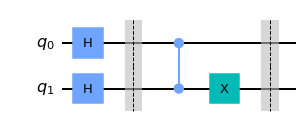

In [21]:
grover_circuit.cz(0,1) # Oracle for |11>
grover_circuit.x(1) # Oracle for |10>
grover_circuit.barrier()
grover_circuit.draw(output='mpl')

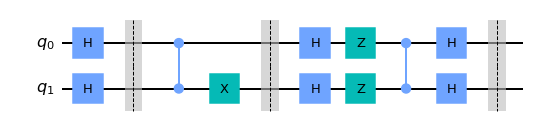

In [22]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.barrier()
grover_circuit.draw(output='mpl')

the CPhase ($CZ$) gate is not supported by the QiController, so we transpile the grover_circuit to the basis gates {$I, U1, U2, U3, CX$}.

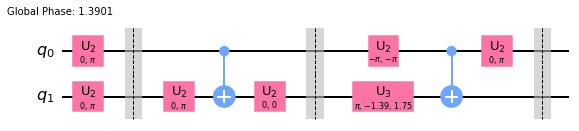

In [23]:
from qiskit.compiler import transpile
transpiled_circuit = transpile(grover_circuit, basis_gates = ['i','u1', 'u2', 'u3', 'cx'])
transpiled_circuit.draw(output='mpl')

In [24]:
sim = Aer.get_backend('aer_simulator')

# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = transpiled_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()

from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

/home/sbenrached/.local/lib/python3.6/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


<IPython.core.display.Math object>

In [25]:
transpiled_circuit.measure_all()

In [26]:
# Create a job by running the circuit on the backend for a number of shots
job = backend.run(transpiled_circuit, 100)

In [27]:
# Retrieve the measurement results in terms of counts
counts = job.get_counts()

In [28]:
print(counts)

{'000': 0, '001': 0, '010': 0, '011': 100}


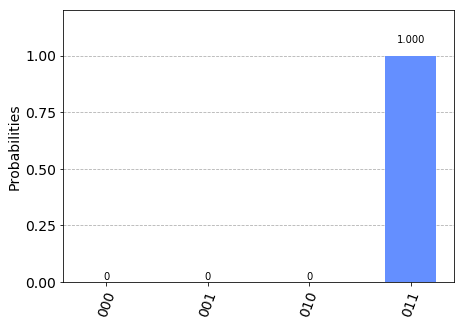

In [29]:
from qiskit.visualization import plot_histogram

# Display the probability distribution of the quantum states
plot_histogram(counts)